In [2]:
import pandas as pd
pd.options.display.max_columns=None

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import pickle

In [3]:
def cm_metrics(true_label,pred_label, labels_):
  cm = confusion_matrix(true_label,pred_label,labels = labels_)
  cmDisp = ConfusionMatrixDisplay(cm,display_labels=labels_)
  recall = { i:cm[i][i]/cm[i].sum()  for i in range(len(cm))}
  precision = { i:cm[i][i]/cm[:,i].sum()  for i in range(len(cm))}
  F1_score = { i: 2 / (1/recall[i] + 1/precision[i]) for i in range(len(cm))}
  accuracy = (cm[0][0]+cm[1][1]+cm[2][2])/cm.sum()
  print('accuracy: ', accuracy)
  print('Recall: \n',recall,'\nPrecision: \n', precision,'\nF1-score: \n',F1_score)
  cmDisp.plot()
  plt.show()
  return None

# Data load and transform

In [4]:
train_df = pd.read_csv("../data/training_data/train_more_features.csv", index_col = 0)

In [5]:
train_df.drop(columns = ['game_id'], inplace = True)


In [6]:
train_df = train_df.astype(dtype={x:np.int8 for x in train_df.columns[:14]})
train_df = train_df.astype(dtype={x:np.float16 for x in train_df.columns[14:-1]})

# Normalisation

In [77]:
col_select = ['H_GK', 'H_attack', 'H_defense', 'H_midfield','A_GK', 'A_attack', 'A_defense', 'A_midfield']
train_df.loc[:,col_select]=train_df.loc[:,col_select]/5

In [8]:
col_select = np.append(col_select ,train_df.columns[:14])
col_select = np.append(col_select ,['Home_result'])

In [9]:
col_mask = [x  for x in train_df.columns if (x not in col_select)]
train_df.loc[:,col_mask]=train_df.loc[:,col_mask]/100


In [10]:
train_df.Home_result=train_df.Home_result.apply(lambda x: np.int8(0) if x>0 else (np.int8(2) if x<0 else np.int8(1)))

In [11]:
X = train_df.loc[:,train_df.columns[:-1]]
y = train_df.Home_result

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=0, stratify=y)

In [13]:
MLPC = MLPClassifier(solver='lbfgs', alpha=0.001, learning_rate_init=0.001, max_iter=1000)

In [14]:
MLPC.fit(X_train, y_train)

/Users/pierreadda/opt/anaconda3/envs/foot_env/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.001, max_iter=1000, solver='lbfgs')

In [15]:
y_train_pred = MLPC.predict(X_train)
y_test_pred = MLPC.predict(X_test)

accuracy:  0.5488311219424136
Recall: 
 {0: 0.8137432188065099, 1: 0.02390659747961453, 2: 0.5775558166862514} 
Precision: 
 {0: 0.5666713306282356, 1: 0.4161290322580645, 2: 0.520518930368017} 
F1-score: 
 {0: 0.6680963378422963, 1: 0.0452155625657203, 2: 0.547556050689319}


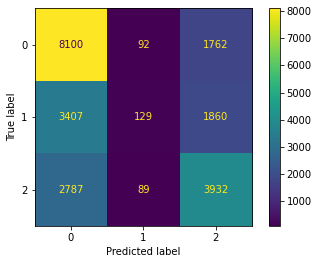

In [16]:
cm_metrics(y_train,y_train_pred,MLPC.classes_)

accuracy:  0.5374306213618519
Recall: 
 {0: 0.797228080747213, 1: 0.023346303501945526, 2: 0.5650066108417805} 
Precision: 
 {0: 0.563338301043219, 1: 0.4, 2: 0.49593810444874276} 
F1-score: 
 {0: 0.6601796407185628, 1: 0.044117647058823525, 2: 0.5282241450350226}


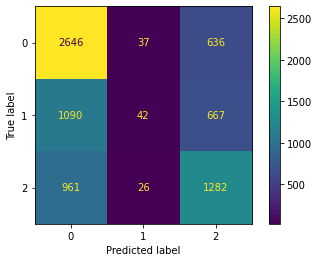

In [17]:
cm_metrics(y_test,y_test_pred,MLPC.classes_)

In [24]:
y_pred_proba = MLPC.predict_proba(X)

In [29]:
y_proba_df = pd.DataFrame({'HomeWin' : y_pred_proba[:,0],'Draw' : y_pred_proba[:,1], 'AwayWin' : y_pred_proba[:,2], 'Result' : y })

In [37]:
y_proba_df.head(1)

,HomeWin,Draw,AwayWin,Result
0,0.1959,0.385481,0.418619,0


In [71]:
y_proba_df.loc[(y_proba_df.Draw >0.33) & (abs(y_proba_df.HomeWin - y_proba_df.AwayWin) <0.14),'Result'].value_counts()
#y_proba_df.loc[abs(y_proba_df.HomeWin - y_proba_df.AwayWin) <0.1,'Result'].value_counts()


1    339
0    300
2    279
Name: Result, dtype: int64

In [75]:
y_pred = MLPC.predict(X)

In [73]:
y_pred[(y_proba_df.Draw >0.33) & (abs(y_proba_df.HomeWin - y_proba_df.AwayWin) <0.14)]=1

accuracy:  0.5459807073954984
Recall: 
 {0: 0.8096135010924433, 1: 0.02376650451702571, 2: 0.5744188608571114} 
Precision: 
 {0: 0.5658469801484914, 1: 0.41204819277108434, 2: 0.5142518986093303} 
F1-score: 
 {0: 0.6661294321844782, 1: 0.044940867279894874, 2: 0.5426727726894254}


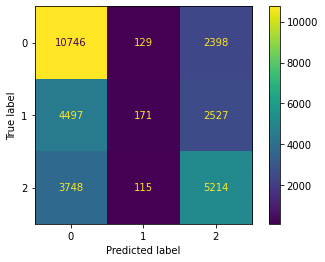

In [76]:
cm_metrics(y,y_pred,MLPC.classes_)

In [92]:
pickle.dump(MLPC,open('../data/Model/mlp_classifier_more_features.pkl','wb'))